# Trabalho 4: Ajuste de curvas por otimização com restrição via método de Levenberg-Marquardt

**Repetir o Trabalho 3 utilizando o método de Levenberg-Marquardt com função de custo MSE e o método de normalização que levou ao melhor resultado com o método de Descida de Gradiente. Comparar os resultados com os obtidos por descida de gradiente.**


In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Recapitulando...

Dada uma função custo $J(x)$ de um problema de otimização com variável de decisão $x$ e a série de Taylor para $dJ(x)$ igual a:

$$dJ(x)=J_x^Tdx+\frac{1}{2}dx^{T}J_{xx}dx+O$$

Para resolver o problema $min_{x}J(x)$ por descida de gradiente utilizamos a aproximação de primeira ordem da série $dJ(x)\cong J_x^Tdx$ com o objetivo de fazer iterativamente $dJ(x)\cong J_x^Tdx=0$.

Como solução utilizamos $x_{k+1}=x_{k}-\alpha J_{x_{k}}$.

O metódo de descida de gradiente converge lentamente para o mínimo $x^*$. Por isso, técnicas de otimização mais elaboradas podem ser utilizadas em substituição. [1]

### Método de newton
A idéia básica é minimizar a aproximação quadrática da função de custo $J(x)$ avaliado no ponto atual $x_k$. Para isso, será utilizada a aproximação de segunda ordem da série de taylor aplicada na função de custo.

$$ dJ(x)\cong J_x^Tdx+\frac{1}{2}dx^{T}J_{xx}dx $$

Considerando a matriz hessiana $J_{xx}$ simétrica e $\frac{dJ(x)}{dx}\cong0$, tem-se

$$
 J_{x}+J_{xx}dx=0 \Rightarrow dx=-J_{xx}^{-1}J_x
$$

Para o problema computacional $d$ é aproximado por $\Delta$, logo:

$$
\Delta x_{k} =-J_{xx}^{-1}J_x \\ \Delta J(x_{k}) = J(x_{k+1})- J(x_{k})
$$

$$ \Delta J(x_k)\cong J_x^T \Delta x+\frac{1}{2}\Delta x^{T}J_{xx} \Delta x $$


Expandindo $\Delta x_{k}$ e $\Delta J({x_k})$  na equação anterior obtemos:

$$
J(x_{k+1}) = J(x_{k})+J_{x_{k}}^{T}(-J_{xx_{k}}^{-1}J_{x_{k}})+\frac{1}{2}(-J_{xx_{k}}^{-1}J_{x_{k}})^{T}J_{xx_{k}}(-J_{xx_{k}}^{-1}J_{x_{k}})
$$

$$
J(x_{k+1}) = J(x_{k}) - J_{x_{k}}^{T}J_{xx_{k}}^{-1}J_{x_{k}}+\frac{1}{2} J_{xx_{k}}^{-1}J_{x_{k}}^{T}J_{x_{k}}
$$


$$
J(x_{k+1}) = J(x_{k}) -\frac{1}{2} J_{xx_{k}}^{-1}J_{x_{k}}^{T}J_{x_{k}}              
$$

O metódo de Newton converge rapidamente e assintoticamente além de resolver o problema de divergência do gradiente-descendente.[1] Em contra partida, para que o método funcione, a matriz hessiana $J_{xx}(x_k)$ precisa ser definida e positiva para todo $x_k$. Infelizmente, no geral, essa garantia não pode ser dada para todas as iterações do algoritmo. Além disso,  o cálculo da hessiana demanda maior esforço analítico e a atualização de $x_k$ requer maior esforço computacional.


### Método de Levenbeg-Marquardt

O método de Levenberg-Marquardt é uma extensão do método de Newton, projetado para melhorar sua convergência e robustez em problemas de otimização.

 Uma das melhorias chave é a incorporação de um parâmetro $\alpha_k$ na matriz Hessiana, $J_{xx_k}$, que substitui $J_{xx_k}$ por $J_{xx_k} + \alpha_k I$, onde $I$ é a matriz identidade e $\alpha_k$ é um escalar positivo.

$$\Delta x_{k} =-[J_{xx_k}+\alpha_{k}I]^{-1}J_{x_k} $$
Esta adição visa contornar limitações de convergência do método de Newton em situações desafiadoras.

$$  x_{k +1} = x_k -[J_{xx_k}+\alpha_{k}I]^{-1}J_{x_k}$$
Isso nos dá a direção e magnitude da mudança nos parâmetros necessária para otimizar a função de erro na iteração $k$ do método de Levenberg-Marquardt.

### 1. Avaliação dos dados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# @brief: importa dados do excel
def GetData():
  df = pd.read_excel("../Trabalho3/Trabalho3dados.xlsx")
  x = df['x']
  y = df['y']
  z = df['z']
  return([x, y, z])

In [3]:
def ZScore(Data):
  return ((Data - np.mean(Data)) / np.std(Data))

def GetNormData(method=ZScore):
  x = GetData()
  for i in range(len(x)):
    x[i] = method(x[i])
  return (x)

def DenormalizeData(Data, Orig):
  return (Data * Orig.std() + Orig.mean())

### 2. Propor uma estrutura para $h$:


In [4]:
"""
  @brief: Função de modelo usada para ajuste de curva
  @Params:
    - p: Valor dos parametros    -> n = 3 (a, b,c)                                     (n x 1)
    - x: Variaveis independentes -> m = 2 (x,y)                                        (m x 1)
  @Return: z = Funcao de ajuste de curva avaliado nos pontos x e com parâmetros p      (m x 1)

"""
def CurveFitFunction(p, x):
    return ((p[0] * x[0]**3) + (p[1] * x[1]**2) + p[2])

### 3. Definir uma medida de erro $J(e)$:

- **Erro Quadrático Médio (MSE):** =$\frac{1}{n}\sum_{i=1}^{n} e_{i}^{2}$

In [5]:
def MSE(zPred, zReal):
    return (np.mean(zReal - zPred)**2)

### 4. Aplicar minimização para obter os parâmetros do modelo.

**Calculando o Gradiente e a matriz Hessiana da função de erro:**


- **Gradiente:**

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (Z_i - \hat{Z}_i)^2 =  \frac{1}{n} \sum_{i=1}^{n} (Z_i - ax_i^3 - by_i^2-c)^2$$
$$\Rightarrow \nabla MSE = -\frac{2}{n}\sum_{i=1}^{n}((Z_i - \hat{Z}_i)[x_i^3, y_i^2, 1]) $$


- **Hessiana:**

  A matriz Hessiana é uma extensão do gradiente que descreve as segundas derivadas parciais da função de erro. Ela é crucial para entender a curvatura da função de erro em relação aos parâmetros e determinar sua forma. Considerando isso, temos:

 $$ \begin{bmatrix}
 \frac{\partial^2 MSE}{\partial a^2}& \frac{\partial^2 MSE}{\partial a \partial b} & \frac{\partial^2 MSE}{\partial a\partial c}\\
\frac{\partial^2 MSE}{\partial b \partial a} & \frac{\partial^2 MSE}{\partial b^2} & \frac{\partial^2 MSE}{\partial b\partial c} \\
 \frac{\partial^2 MSE}{\partial c\partial a}& \frac{\partial^2 MSE}{\partial c\partial b} & \frac{\partial^2 MSE}{\partial c^2}
\end{bmatrix} $$

 Explicitando ainda mais:

 (seguindo a lógica doq foi feito para a diagonal, se tá certo nunca saberemos)
  
  $$J_{aa} = \frac{\partial^2 MSE}{\partial a^2} = \frac{2}{n} \sum_{i=1}^n(x_i^3)^2$$


  $$J_{bb} = \frac{\partial^2 MSE}{\partial b^2} = \frac{2}{n} \sum_{i=1}^n(y_i^2)^2$$

  $$J_{cc} = \frac{\partial^2 MSE}{\partial c^2} = \frac{2}{n} \sum_{i=1}^n(1)^2 = 2 $$
  
  $$J_{ab} =\frac{\partial^2 MSE}{\partial a \partial b}=\frac{2}{n} \sum_{i=1}^nx_i^3y_i^2$$

  $$J_{ac} =\frac{\partial^2 MSE}{\partial a\partial c}=\frac{2}{n} \sum_{i=1}^nx_i^3$$

  $$J_{ba} =\frac{\partial^2 MSE}{\partial b \partial a}=\frac{2}{n} \sum_{i=1}^nx_i^3y_i^2$$

  $$J_{bc} =\frac{\partial^2 MSE}{\partial b \partial c}=\frac{2}{n} \sum_{i=1}^ny_i^2$$

  $$J_{ca} =\frac{\partial^2 MSE}{\partial c\partial a}=\frac{2}{n} \sum_{i=1}^nx_i^3$$

  $$J_{cb} =\frac{\partial^2 MSE}{\partial c\partial b}=\frac{2}{n} \sum_{i=1}^ny_i^2$$



In [6]:
def GradMSE(x, zReal, zPred):
    n=len(x[0])
    errors = (zPred - zReal)
    GradA = 2/n * np.sum((x[0] ** 3) * errors)
    GradB = 2/n * np.sum((x[1] ** 2) * errors)
    GradC = 2/n * np.sum((1) * errors)
    return np.array([GradA, GradB, GradC])

def HessianaMSE(x):
    n=len(x[0])
    HessianAA = 2/n * np.sum(x[0] ** 6)
    HessianAB = 2/n * np.sum((x[0] ** 3) * (x[1] ** 2))
    HessianAC = 2/n * np.sum(x[0] ** 3)
    HessianBA = 2/n * np.sum((x[0] ** 3) * (x[1] ** 2))
    HessianBB = 2/n * np.sum(x[1] ** 4)
    HessianBC = 2/n * np.sum(x[1] ** 2)
    HessianCA = 2/n * np.sum(x[0] ** 3)
    HessianCB = 2/n * np.sum(x[1] ** 2)
    HessianCC = 2
    return np.array([[HessianAA, HessianAB, HessianAC],
                     [HessianBA, HessianBB, HessianBC],
                     [HessianCA, HessianCB, HessianCC]])

In [45]:
def CheckCost(HistCost, tol=0.0001):
  if (len(HistCost) <= 2):
    return False
  return (abs(HistCost[-1] - HistCost[-2]) < tol)


def LevenbergMarquardt(p, K, tol, alpha):
    HistCost =  []
    DataNorm = GetNormData()
    zReal = DataNorm[2]
    while (CheckCost(HistCost) == False):
        zPred = CurveFitFunction(p, DataNorm)
        HistCost.append(MSE(zPred, zReal))
        Jx = GradMSE(DataNorm, zReal, zPred)
        Jxx = HessianaMSE(DataNorm)               # Hessiana Analítica
        #deltaP = Jx * alpha                      # Gradiente
        #deltaP = np.dot(np.linalg.inv(Jxx), Jx)  # Metodo de Newton
        deltaP = np.dot(np.linalg.inv(Jxx + np.dot(alpha, np.eye(3))), Jx)
        newP = p - deltaP
        newError = MSE(CurveFitFunction(newP, DataNorm), zReal)
        if (newError >= HistCost[-1]):
          alpha *= 10 # gradiente
        else:
          p = newP
          alpha /= 10 # newton
        K -= 1
        if (K == 0):
          break
    return (p, HistCost)


In [17]:
def GetZDenorm(p, ZOrig):
  x = GetNormData()
  X, Y = np.meshgrid(np.linspace(min(x[0]), max(x[0]), 100),
                     np.linspace(min(x[1]), max(x[1]), 100))
  ZNorm = (CurveFitFunction(p, [X, Y]))
  ZDenorm = DenormalizeData(CurveFitFunction(p, [X, Y]), ZOrig)
  return (ZDenorm)

def GetSurface(x, k, tol, alpha):
  p, HistCost = LevenbergMarquardt([1.0, 1.0, 1.0], k, tol, alpha)
  X, Y = np.meshgrid(np.linspace(min(x[0]), max(x[0]), 100),
                     np.linspace(min(x[1]), max(x[1]), 100))
  Z = GetZDenorm(p, x[2])
  return (X, Y, Z, HistCost)

def PlotSurface(fig, X, Y, Z):
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.plot_surface(X, Y, Z, alpha=0.8, cmap='viridis')
  ConfGraph3D(ax, 'x', 'y', 'z', "Ajuste de curva por MSE  e Levenberg-Marquardt")
  return (ax)

def PlotCosts(fig, Hist):
  ax = fig.add_subplot(1, 2, 2)
  k = np.linspace(0, len(Hist), len(Hist), dtype=int)
  print(Hist)
  print(k)

  ax.plot(k, Hist)
  ax.set_xlabel('Iterações (k)')
  ax.set_ylabel('Custo')
  ax.set_title("Histórico de custo da função MSE")
  ax.grid(True)

def TestCostFunc(K=1000, tol=0.00001, alpha=0.001):
  x = GetData()
  fig = plt.figure(figsize=(12, 6))
  X, Y, Z, HistCost = GetSurface(x, K, tol, alpha)
  ax = PlotSurface(fig, X, Y, Z)
  ax.scatter(x[0], x[1], x[2], c='blue', marker='o')
  PlotCosts(fig, HistCost)

def ConfGraph3D(ax, x, y, z, title):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)

Analisando o metódo de LevenbergMarquardt para valores pequenos de $\alpha$,  observamos que os pontos desnormalizados se acomodam a superficie encontrada, pois o algoritmo se assemelha mais ao método de Gauss-Newton .
$$ J_{xx_k}+\alpha_{k}I\approx J_{xx_{k}}$$
$$\Delta x_{k} =-J_{xx_k}^{-1}J_{x_k}$$



[3.9999999999999982, 3.5243235555239478e-15, 1.8463988126371213e-31]
[0 1 3]


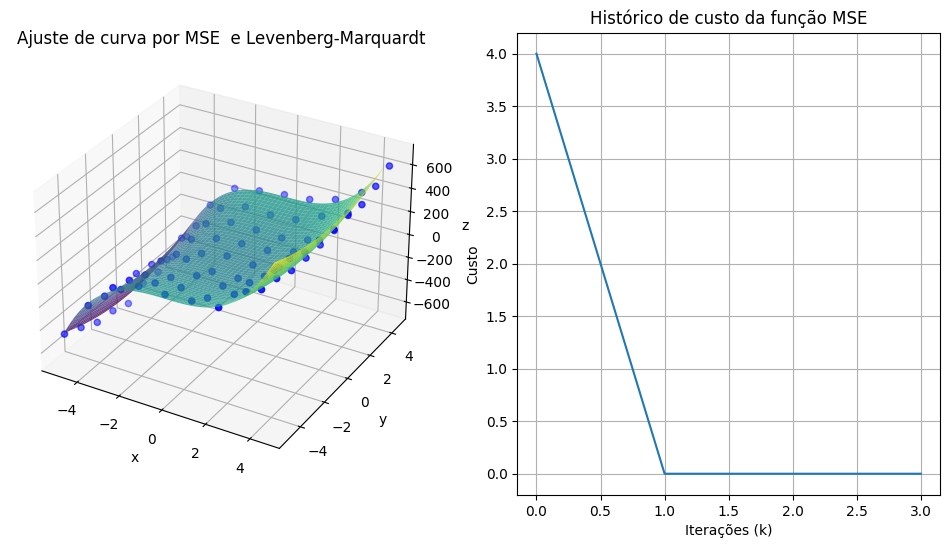

In [46]:
TestCostFunc(alpha=0.0000001)


Ao aumentar consideravelmente o valor do $\alpha$,

$$J_{xx_k}+\alpha_{k}I\approx \alpha_{k}I$$
$$ \Delta x_{k} =-\alpha_{k}^{-1}J_{x_k} $$



[3.9999999999999982, 0.0008237928252785479, 9.501822144715985e-09, 4.1471625660326636e-15]
[0 1 2 4]


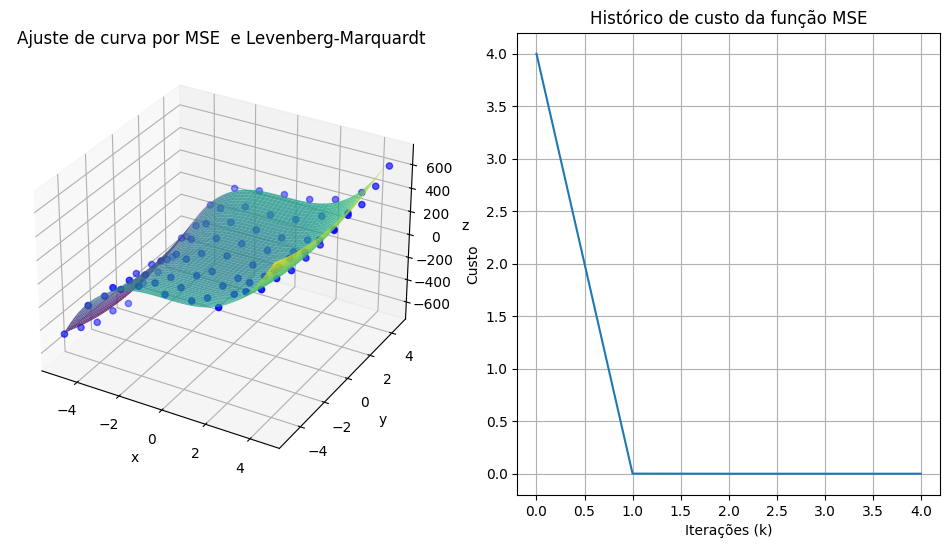

In [47]:
TestCostFunc(alpha=0.05)

# Referências bibliográficas

**[1]** HAYKIN, S. **Neural Networks and Learning Machines**. 3ed. Pearson, 2009

**[2]** LEWIS, F.L.;VRABIE,D.L;SYRMOS,V.L. **Optimal Control**. 3ed. Wiley, 2012
